## Importing libs

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
sns.set() # apply the seaborn defaults to plotted figures (e.g. theme, scaling, color palette), instead of matplotlib's

In [3]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

2.0.0


In [4]:
import warnings
from time import time, strftime

In [6]:
strftime('%X')

'15:51:28'

## Preparing the Fashion-MNIST dataset
[Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) is a dataset of Zalando’s article images, consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28×28 grayscale image, associated with a label from 10 classes.

**NOTE:** you should have the .csv files in the directory listed below

In [35]:
# confirm that you have fashion-mnist_train.csv and fashion-mnist_test.csv (unzipped)
!ls ../fashion-mnist-dataset/

fashion-mnist_test.csv
fashion-mnist_train.csv
README.txt


In [49]:
PATH_TO_DATA = os.path.join("..", "fashion-mnist-dataset")

# the datasets have the label on the first column and the image pixels on the following 784
train_dataset_csv = pd.read_csv(os.path.join(PATH_TO_DATA, "fashion-mnist_train.csv"), delimiter=',')
test_dataset_csv = pd.read_csv(os.path.join(PATH_TO_DATA, "fashion-mnist_test.csv"), delimiter=',')

In [63]:
IMG_WIDTH = IMG_HEIGHT = 28
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH) # grayscale images
IMG_FLAT_SHAPE = (IMG_HEIGHT*IMG_WIDTH, )

CLASS_NAME = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
              'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
CLASS_COUNT = len(CLASS_NAME)

## Split train into train + validation

In [5]:
# random seed for splitting the data deterministically
RANDOM_SEED = 886
np.random.seed(RANDOM_SEED)

In [64]:
from sklearn.model_selection import train_test_split

train_data, validation_data = train_test_split(train_dataset_csv, train_size=0.8, shuffle=True, random_state=RANDOM_SEED)
print(f"train: {train_data.shape}") # 80%
print(f"validation: {validation_data.shape}") # 20%

total: (60000, 785)

train: (48000, 785)
validation: (12000, 785)


## Separate labels and images

In [69]:
ys_train = train_data["label"].values
ys_val   = validation_data["label"].values
ys_test  = test_dataset_csv["label"].values

print(ys_train.shape, "min:", ys_train.min(), "max:", ys_train.max())
print(ys_val.shape,   "min:", ys_val.min(),   "max:", ys_val.max())
print(ys_test.shape,  "min:", ys_test.min(),  "max:", ys_test.max())

(48000,) min: 0 max: 9
(12000,) min: 0 max: 9
(10000,) min: 0 max: 9


In [71]:
xs_train = train_data.loc[:, train_data.columns != "label"].values
xs_val   = validation_data.loc[:, validation_data.columns != "label"].values
xs_test  = test_dataset_csv.loc[:, test_dataset_csv.columns != "label"].values

print(xs_train.shape, "min:", xs_train.min(), "max:", xs_train.max())
print(xs_val.shape,   "min:", xs_val.min(),   "max:", xs_val.max())
print(xs_test.shape,  "min:", xs_test.min(),  "max:", xs_test.max())

(48000, 784) min: 0 max: 255
(12000, 784) min: 0 max: 255
(10000, 784) min: 0 max: 255


## Normalize images and one-hot encode labels
We'll forget about the test set for now.. assume it doesn't exist (we'll come back to it at the end).

In [74]:
print(f"xs_train: mean={xs_train.mean():>8.4f}, stddev={xs_train.std():>7.4f}")

# NOTE that we must use stats from train data to normalize the val and test sets aswell
mean, std = xs_train.mean(), xs_train.std()
X_train = (xs_train - mean) / std

print(f"X_train:  mean={X.mean():>8.4f}, stddev={X.std():>7.4f}")

xs_train: mean= 72.9774, stddev=89.9809
X_train:  mean= -0.0000, stddev= 1.0000


In [75]:
X_val = (xs_val - mean) / std
print(f"xs_val: mean={xs_val.mean():>8.4f}, stddev={xs_val.std():>7.4f}")
print(f"X_val:  mean={X_val.mean():>8.4f}, stddev={X_val.std():>7.4f}") # mean should be close to 0 and stddev close to 1

xs_val: mean= 72.8747, stddev=89.9105
X_val:  mean= -0.0011, stddev= 0.9992


In [77]:
def onehot_encode(ys):
    n_examples, *_ = ys.shape
    onehot = np.zeros(shape=(n_examples, CLASS_COUNT))
    onehot[np.arange(n_examples), ys] = 1
    return onehot

In [78]:
Y_train = onehot_encode(ys_train)
print(ys_train.shape, Y_train.shape)

(48000,) (48000, 10)


In [79]:
Y_val = onehot_encode(ys_val)
print(ys_val.shape, Y_val.shape)

(12000,) (12000, 10)


In [9]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [11]:
# image values range from 0 to 255, and 
# label values range from 0 to 9

print("Train + validation:")
print("  images:", train_images.shape, train_images.dtype)
print("  labels:", train_labels.shape, train_labels.dtype)

print("Test:")
print("  images:", test_images.shape, test_images.dtype)
print("  labels:", test_labels.shape, test_labels.dtype)

Train + validation:
  images: (60000, 28, 28) uint8
  labels: (60000,) uint8
Test:
  images: (10000, 28, 28) uint8
  labels: (10000,) uint8


In [12]:
def show_image(img_index, images, labels, figsize=None):
    ''' Shows the image represented by the `img_index`-th row of `images` '''
    if figsize != None:
        fig = plt.figure(figsize=figsize)
    plt.imshow(images[img_index], cmap='binary', vmin=0, vmax=255)
    plt.title(f"{CLASS_NAME[labels[img_index]]} ({img_index})")
    plt.axis(False)
    plt.show()

In [13]:
def show_random_images(images, labels, examples_per_class=8):
    ''' Shows `examples_per_class` randomly selected images for each class '''
    fig = plt.figure(figsize=IMG_SHAPE)    
    for i in range(CLASS_COUNT):
        img_indexes = np.random.choice(np.where(labels == i)[0], examples_per_class)
        for j, img_index in enumerate(img_indexes):
            fig.add_subplot(CLASS_COUNT, examples_per_class,
                            i * examples_per_class + j + 1)
            plt.imshow(images[img_index], cmap='binary', vmin=0, vmax=255)
            plt.title(f"{CLASS_NAME[labels[img_index]]} ({img_index})")
            plt.axis(False)
    plt.show()

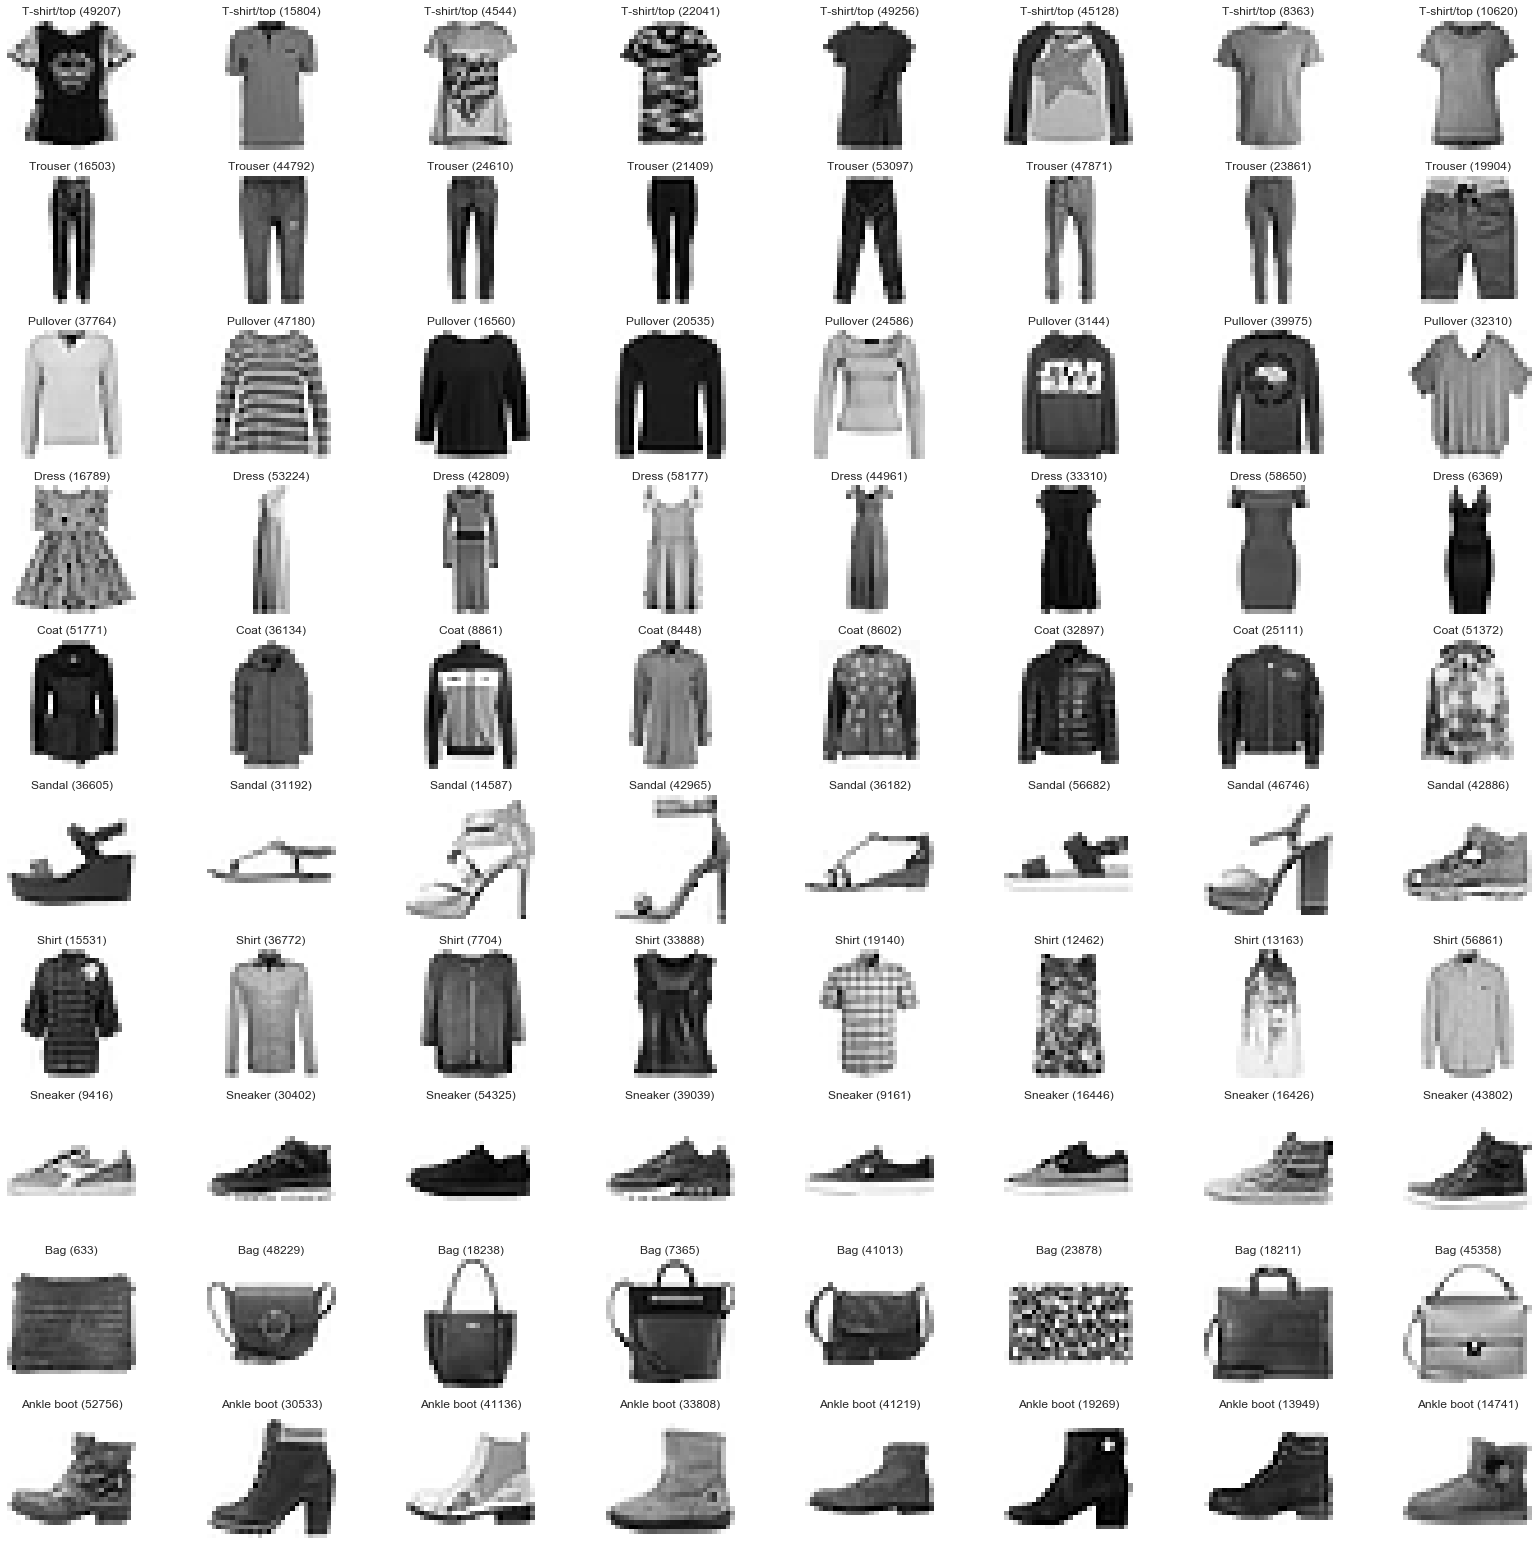

In [14]:
show_random_images(train_images, train_labels)

## 1. Baseline
Explore Neural Networks with Fashion-MNIST. What is the accuracy? Describe your Neural Network architecture.

In [15]:
# ref.: https://www.tensorflow.org/tutorials/keras/classification

model = keras.Sequential([
    keras.layers.Flatten(input_shape=IMG_SHAPE), # 28 * 28 = 784 pixels
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

In [16]:
# NOTE using 'sparse_categorical_crossentropy' instead of 'categorical_crossentropy' since `labels` isn't one-hot encoded
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [18]:
n_epochs = 64
batch_size = 1024
validation_frac = 0.2

In [19]:
history = model.fit(train_images, train_labels, 
                    epochs=n_epochs,
                    batch_size=batch_size,
                    validation_split=validation_frac).history

Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 1s 19us/sample - loss: 30.2187 - accuracy: 0.6316 - val_loss: 9.4708 - val_accuracy: 0.7431
Epoch 2/64
48000/48000 [==============================] - 0s 3us/sample - loss: 7.3470 - accuracy: 0.7621 - val_loss: 6.1177 - val_accuracy: 0.7669
Epoch 3/64
48000/48000 [==============================] - 0s 4us/sample - loss: 5.3281 - accuracy: 0.7790 - val_loss: 4.7923 - val_accuracy: 0.7822
Epoch 4/64
48000/48000 [==============================] - 0s 3us/sample - loss: 4.1283 - accuracy: 0.7894 - val_loss: 4.1996 - val_accuracy: 0.7790
Epoch 5/64
48000/48000 [==============================] - 0s 3us/sample - loss: 3.4873 - accuracy: 0.7991 - val_loss: 3.5360 - val_accuracy: 0.7873
Epoch 6/64
48000/48000 [==============================] - 0s 3us/sample - loss: 2.9764 - accuracy: 0.8054 - val_loss: 3.1659 - val_accuracy: 0.7974
Epoch 7/64
48000/48000 [==============================] - 0s

Epoch 56/64
48000/48000 [==============================] - 0s 4us/sample - loss: 0.2450 - accuracy: 0.9125 - val_loss: 0.7460 - val_accuracy: 0.8551
Epoch 57/64
48000/48000 [==============================] - 0s 4us/sample - loss: 0.2412 - accuracy: 0.9125 - val_loss: 0.7607 - val_accuracy: 0.8520
Epoch 58/64
48000/48000 [==============================] - 0s 3us/sample - loss: 0.2358 - accuracy: 0.9147 - val_loss: 0.7456 - val_accuracy: 0.8530
Epoch 59/64
48000/48000 [==============================] - 0s 3us/sample - loss: 0.2356 - accuracy: 0.9151 - val_loss: 0.7484 - val_accuracy: 0.8526
Epoch 60/64
48000/48000 [==============================] - 0s 4us/sample - loss: 0.2382 - accuracy: 0.9118 - val_loss: 0.7517 - val_accuracy: 0.8544
Epoch 61/64
48000/48000 [==============================] - 0s 3us/sample - loss: 0.2342 - accuracy: 0.9155 - val_loss: 0.7631 - val_accuracy: 0.8518
Epoch 62/64
48000/48000 [==============================] - 0s 3us/sample - loss: 0.2310 - accuracy: 0.9167

In [20]:
print(history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [21]:
def plot_history(history):
    plot_title = "Train history"

    # leave only "loss" and "val_loss" for plotting
    loss_data = pd.DataFrame({k: v for k, v in history.items() if (k == "loss" or k == "val_loss")})
    loss_data.index += 1 # start counting the epochs at 1, not 0

    lineplot = sns.lineplot(data=loss_data)
    lineplot.set_title(plot_title)
    lineplot.set_xlabel("epoch")
    lineplot.set_ylabel("Loss")
    plt.show()

    # leave only "accuracy" and "val_accuracy" for plotting
    acc_data = pd.DataFrame({k: v for k, v in history.items() if (k == "accuracy" or k == "val_accuracy")})
    acc_data.index += 1 # start counting the epochs at 1, not 0
    lineplot = sns.lineplot(data=acc_data)
    lineplot.set_title(plot_title)
    lineplot.set_xlabel("epoch")
    lineplot.set_ylabel("Accuracy")
    plt.show()

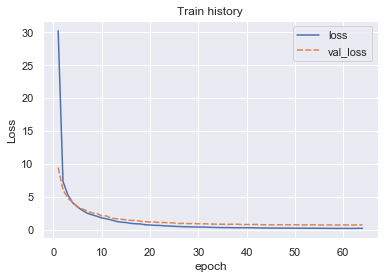

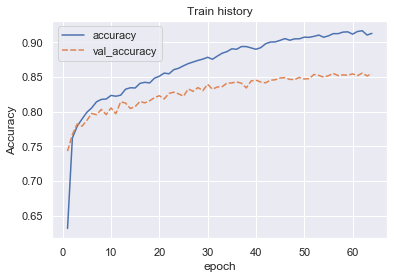

In [22]:
plot_history(history)

In [23]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

10000/1 - 0s - loss: 0.8462 - accuracy: 0.8419

Test accuracy: 0.8419


In [24]:
predictions = model.predict(test_images)

In [25]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(CLASS_NAME[predicted_label],
                                         100*np.max(predictions_array),
                                         CLASS_NAME[true_label]),
                                         color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

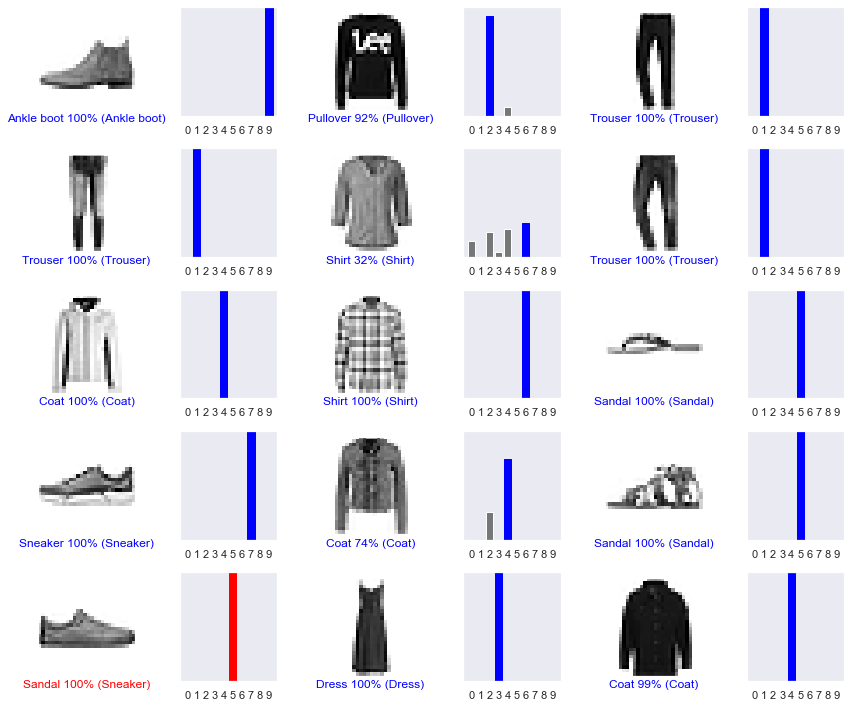

In [26]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

In [27]:
from sklearn.metrics import confusion_matrix, f1_score

In [28]:
def print_cm(ys, ys_pred, class_names, figsize=(10, 9), fontsize=12):
    #cm = confusion_matrix(ys, ys_pred)
    #df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    cm = np.flip(confusion_matrix(ys, ys_pred), axis=0)
    df_cm = pd.DataFrame(cm, index=class_names[::-1], columns=class_names)
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    heatmap.set_ylim(*heatmap.get_xlim())
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

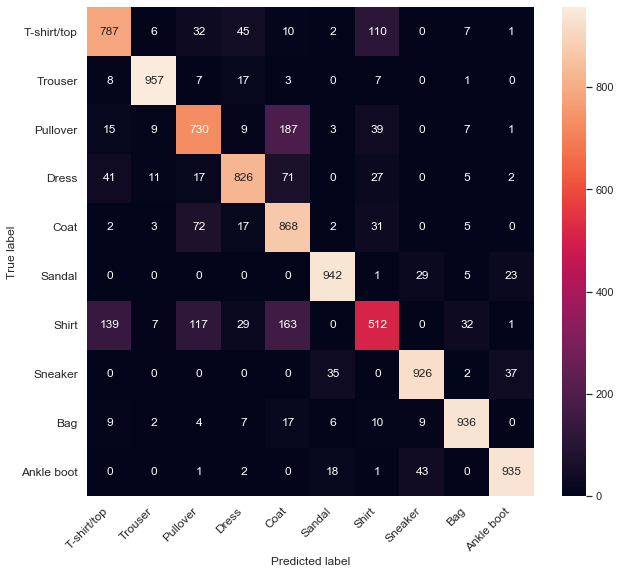

In [29]:
print_cm(test_labels, np.argmax(predictions, axis=1), list(CLASS_NAME.values()))

## 2. Using PCA
Re-do the ﬁrst experiment considering the PCA dimensionality reduction. Consider three diﬀerent energies (variance) for reducing the image dimensionality. What are the conclusions when using PCA in this problem? Does the accuracy improve?

## 3. Using Autoencoders
Re-do the ﬁrst experiment considering Autoencoders for reducing the image dimensionality. Consider two diﬀerent latent vector size for reducing the image dimensionality. What are the conclusions when using Autoencoders in this problem? Does accuracy improve?

Autoencoders are a branch of neural network which attempt to compress the information of the input variables into a reduced dimensional space and then recreate the input data set. Typically the autoencoder is trained over a number of iterations using gradient descent, minimizing the mean squared error. The key component is the “bottleneck” hidden layer. This is where the information from the input has been compressed. By extracting this layer from the model, each node can now be treated as a variable in the same way each chosen principal component is used as a variable in following models.


## 4. Using clustering techniques
Explore two clustering algorithms using the reduced features (PCA or Autoencoders). Do the clusters make sense? Check the validity/quality of your clusters.